# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

## 0 Prerequisites

### 0.0 Import packages and ModelClass

In [76]:
%load_ext autoreload
%autoreload 2

# standard packages
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

# local modules
import figs
import analyse as ana
import validate
from HAHModel import HAHModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.1 Import data for equivalence scale and life cycle income profile

In [77]:
# read data
data = pd.read_excel(
    io='equiscale.xlsx',
    sheet_name='output')

# adjust income profile and slice
Tr = 65-25 # retirement age - par.Tmin
pension = 0.75 # adjustment for drop in income at retirement

data['chi'] = data['chi'].interpolate(method='linear')+0.1 # quick fix to get mean ca. one
data = data.iloc[3:-3,:]
data['chi'].iloc[Tr:] = pension*np.mean(data['chi'].iloc[Tr:])

# extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float') 

## 1 Baseline model

In [78]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={
        'beta':0.95, # try lower beta to get more debt in early stage of life
        'zeta':10, # increased utility cost of default, does it matter?
        'kappa':0.0,
        'nu':0.3,
        'thetab':250,
        'K':8.8,  
        'C_buy':0.0,   # JEJA sets the buyer cost to zero 
        'chi':chi,
        'n':n,
        'Nd':10,
        'Nm':15,
        'Nx':20,
        'Na':15
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
model_baseline.solve()
model_baseline.simulate()
#model_baseline.save()

 t = 3 solved in 77.9 secs
 t = 2 solved in 54.5 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 72.7 secs
 total stay-time  = 12.9 secs
 total ref-time   = 20.5 secs
 total buy-time   = 14.3 secs
 total rent-time   = 12.0 secs
 full model solved in = 132.4 secs
model simulated in 61.2 secs
numba precompiled in 197.5 secs
 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.1 secs
 v_bar and q computed in 1.0 secs
 solved stayer problem in 0.3 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.3 secs
 v_bar and q computed in 1.1 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 1.3 secs
 v_bar and q compute

In [93]:
# simulate the model forward to reach stable bequest distribution
import steady_state
np.random.seed(1995)
par = model_baseline.par
sim = model_baseline.sim
draws1 = np.random.uniform(size=par.simN)
draws2 = np.random.uniform(size=(par.T*par.simN))
draws3 = np.random.lognormal(mean=par.mu_a0,sigma=par.sigma_a0,size=par.simN) # fixed draws for all models
assert np.all(np.isclose(sim.a0,draws3)), 'draws are not equal to initial wealth'
#steady_state.bequest_loop(model_baseline,draws,bequest_guess=1.65,step_size=0.99)

### 1.0 Decision Functions

In [56]:
#figs.decision_functions(model_baseline)

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

### 1.1 Life Cycle Behaviour

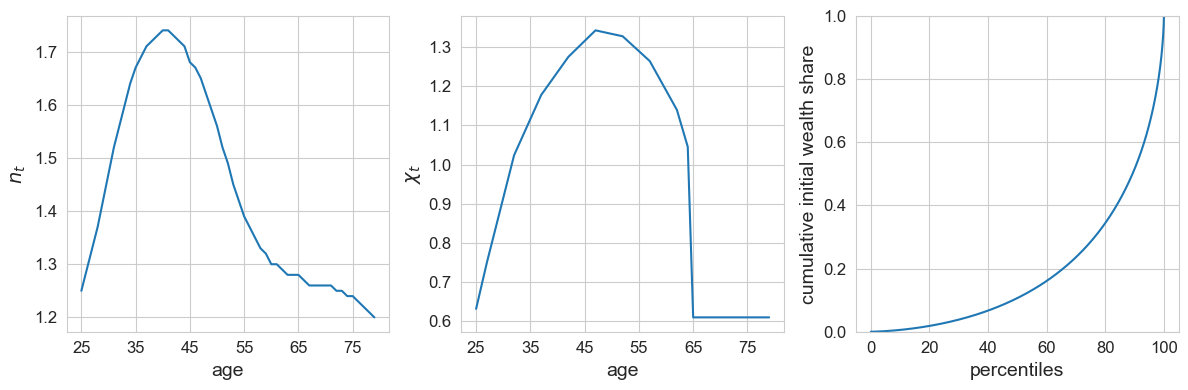

In [5]:
# plot calibration inputs
figs.n_chi_iniwealth(model_baseline,data)

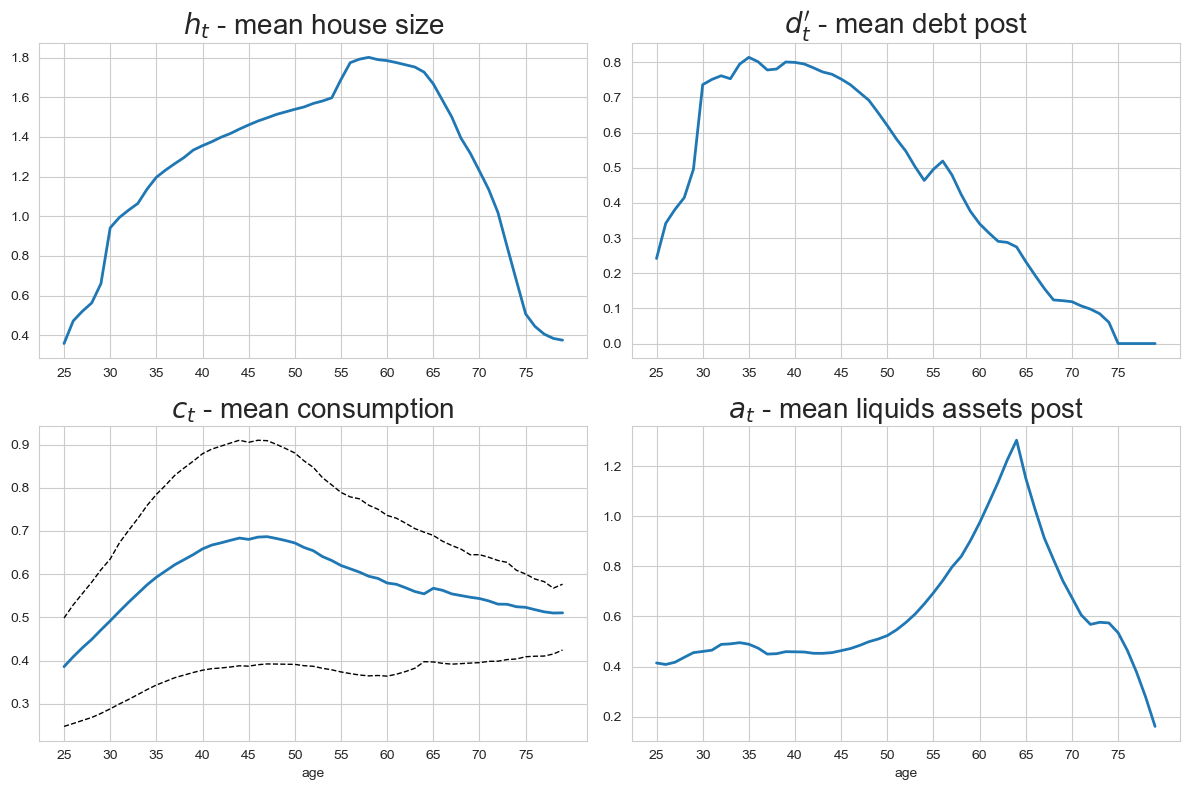

In [6]:
# average behaviour over the life cycle
figs.lifecycle_full(model_baseline)

### 1.2 Life Cycle Behaviour - Model vs. Data

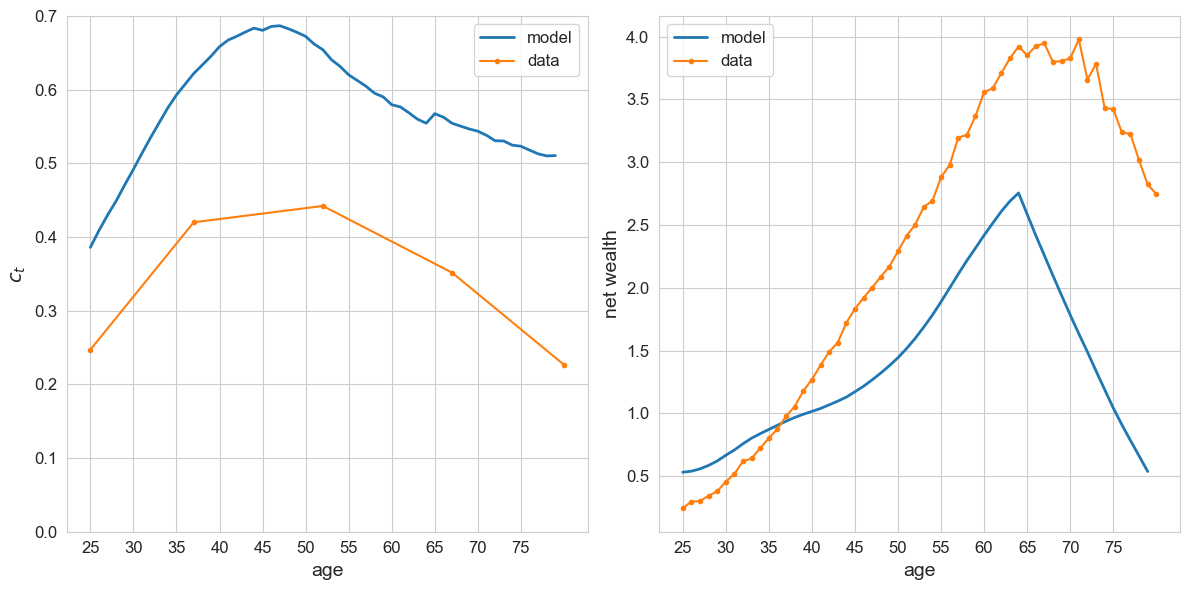

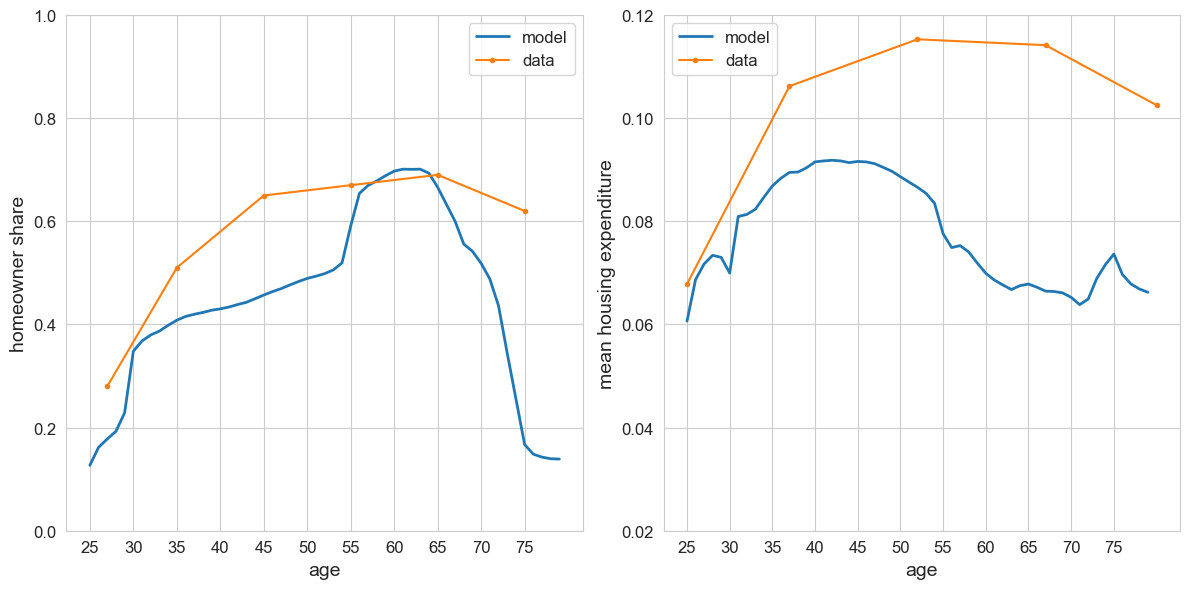

/Users/Christian/Dropbox/KU - Polit/KA/Thesis/MScThesis-2022/figs.py:384: RuntimeWarning: invalid value encountered in true_divide
  DA_shares = np.sum(b_dp_da,axis=1)/np.sum(bool_dp,axis=1)


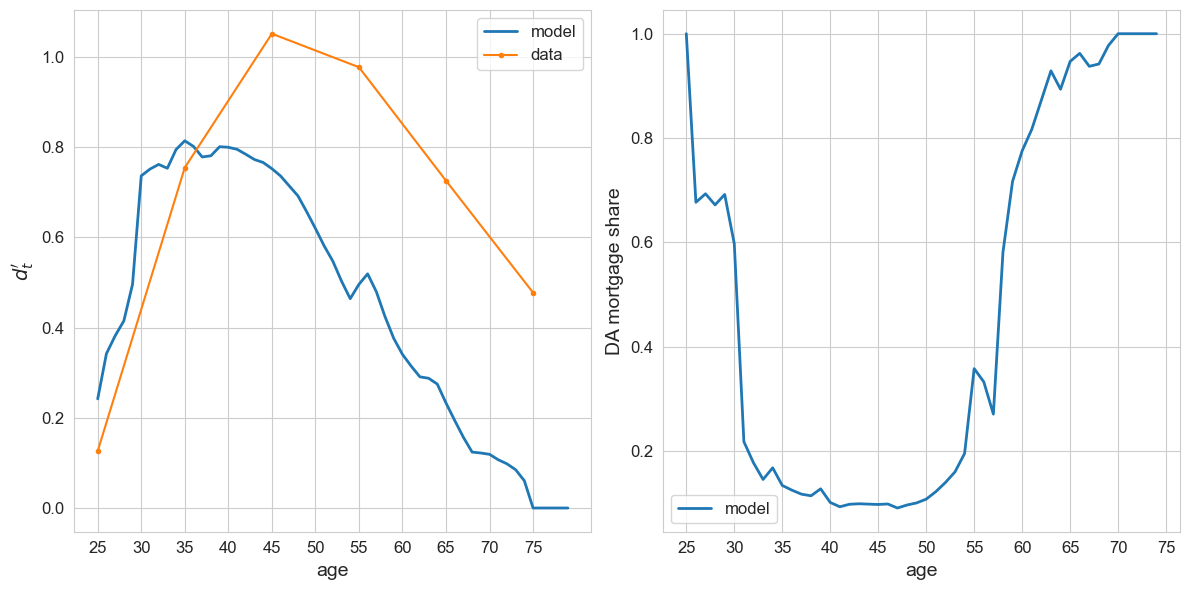

In [17]:
figs.lifecycle_consav(model_baseline)
figs.lifecycle_housing(model_baseline)
figs.lifecycle_mortgage(model_baseline)

### 1.3 Validate simulation

In [19]:
validate.val_sim(model_baseline)
print()
validate.val_finreg(model_baseline)
print()
validate.val_inc_calib_targets(model_baseline)


there are 0 cases of negative consumption
there is no uncollateralised debt in the simulation
there are no instances of neither buying nor renting
there are no errors in the housing stock

mean interest deduction is 0.014995
average mortgage size at origination is 2.2719
the share of DA mortgages at origination is 1.0000
mean LTV is 0.7820 and mean DTI is 1.3041 at mortgage origination

taxes to labour income is 0.3537
median pre tax income is 0.6097
mean property tax is 0.0121
mean pre tax income is 1.0058


### 1.4 Aggregate moments 

In [9]:
# targeted model moments
names_targ, moments_targ = ana.model_moments_targ(model_baseline)
print('Targeted moments from baseline model:')
for i in range(len(names_targ)):
    print(f'  {names_targ[i]} = {moments_targ[i]:.4f}')

Targeted moments from baseline model:
  Aggregate net worth / (annual) labour income = 1.3949
  Annual fraction of houses sold = 0.0501
  Home ownership rate of <35 y.o. = 0.2769
  Mean NW at age 75 / mean NW at age 50 = 0.7224
  Share of households leaving no bequest = 0.4726
  Taxes to labour income = 0.3537


In [10]:
# untargeted model moments
names, moments = ana.model_moments(model_baseline)
print('Untargeted moments from baseline model:')
for i in range(len(names)):
    print(f'  {names[i]} = {moments[i]:.4f}')

Untargeted moments from baseline model:
  Homeowner share = 0.4448
  Mean house size = 2.7999
  Average housing expenditure = 0.0774
  Mean mortgage size = 1.7394
  Share of homeowners with mortgage = 0.5860
  DA mortgage share = 0.3621
  Average LTV ratio = 0.7046
  Average DTI ratio = 1.2452
  Gini wealth coefficient = 0.6811


### 1.5 Discrete choices over the lifecycle

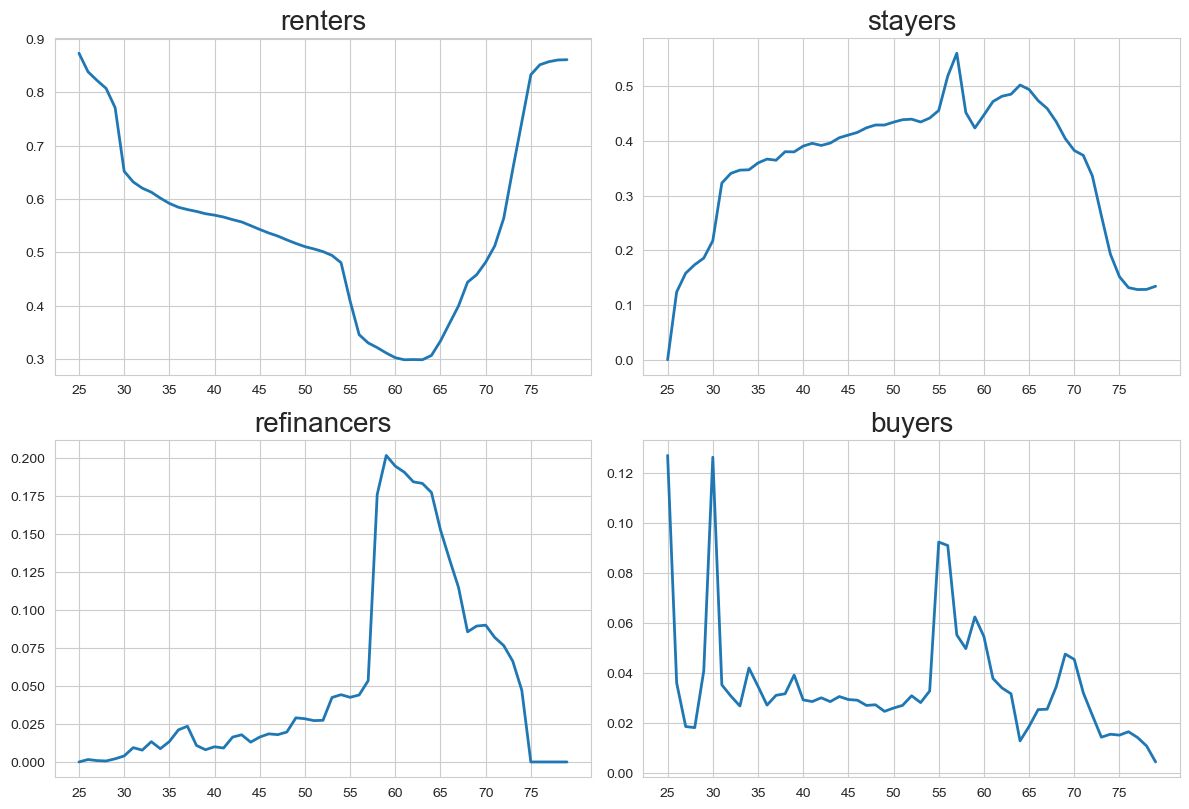

In [11]:
figs.homeownership(model_baseline)

### 1.6 Inspect the life cycle profile of a given household

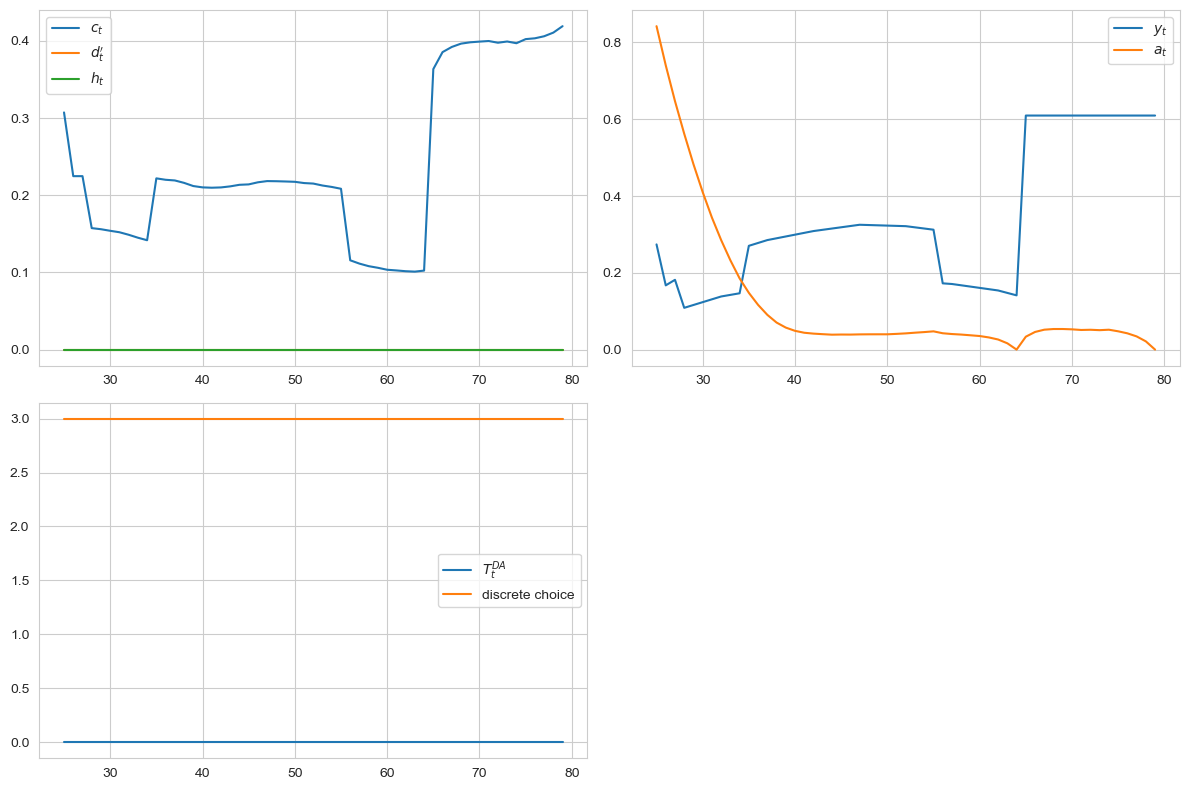

In [26]:
figs.example_household(model_baseline,hh_no=51_000)

## 2 Model without interest rate deduction - no change in house price

In [12]:
# initialise an instance of baseline model
model_nodeduct = HAHModelClass(
    name='baseline',
    par={
        'beta':0.95, # try lower beta to get more debt in early stage of life
        'zeta':10, # increased utility cost of default, does it matter?
        'kappa':0.0,
        'nu':0.3,
        'thetab':250,
        'K':8.8,  
        'C_buy':0.0, 
        'chi':chi,
        'n':n,
        'do_print':True,
        'include_unemp':False,
        'Nd':10,
        'Nm':15,
        'Nx':20,
        'Na':15,
        'tau_r0':0.0,
        'tau_r1':0.0
        })

model_nodeduct.precompile_numba() # solve model with very coarse grids --> speed gains
model_nodeduct.solve()
model_nodeduct.simulate()

 t = 3 solved in 63.1 secs
 t = 2 solved in 77.2 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 93.2 secs
 total stay-time  = 15.3 secs
 total ref-time   = 11.3 secs
 total buy-time   = 10.9 secs
 total rent-time   = 9.6 secs
 full model solved in = 140.3 secs
model simulated in 66.9 secs
numba precompiled in 212.5 secs
 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.2 secs
 v_bar and q computed in 1.0 secs
 solved stayer problem in 0.4 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.3 secs
 v_bar and q computed in 1.1 secs
 solved stayer problem in 0.2 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 1.3 secs
 v_bar and q computed

In [20]:
steady_state.bequest_loop(model_nodeduct,draws,bequest_guess=1.68,step_size=0.99)

iteration = 1, discrepancy in means = -0.033022
iteration = 2, discrepancy in means = -0.023538
iteration = 3, discrepancy in means = -0.016701
iteration = 4, discrepancy in means = -0.011914
iteration = 5, discrepancy in means = -0.008502
iteration = 6, discrepancy in means = -0.006049
iteration = 7, discrepancy in means = -0.004308
iteration = 8, discrepancy in means = -0.003069
iteration = 9, discrepancy in means = -0.002191
iteration = 10, discrepancy in means = -0.001550
iteration = 11, discrepancy in means = -0.001094
iteration = 12, discrepancy in means = -0.000775
iteration = 13, discrepancy in means = -0.000538
iteration = 14, discrepancy in means = -0.000378
iteration = 15, discrepancy in means = -0.000269
iteration = 16, discrepancy in means = -0.000197
iteration = 17, discrepancy in means = -0.000138
iteration = 18, discrepancy in means = -0.000099
iteration = 19, discrepancy in means = -0.000071
iteration = 20, discrepancy in means = -0.000050
iteration = 21, discrepancy i

In [21]:
validate.val_sim(model_nodeduct)
print()
validate.val_finreg(model_nodeduct)

there are 0 cases of negative consumption
there is no uncollateralised debt in the simulation
there are no instances of neither buying nor renting
there are no errors in the housing stock

mean interest deduction is 0.000000
average mortgage size at origination is 2.1330
the share of DA mortgages at origination is 1.0000
mean LTV is 0.6996 and mean DTI is 1.0913 at mortgage origination


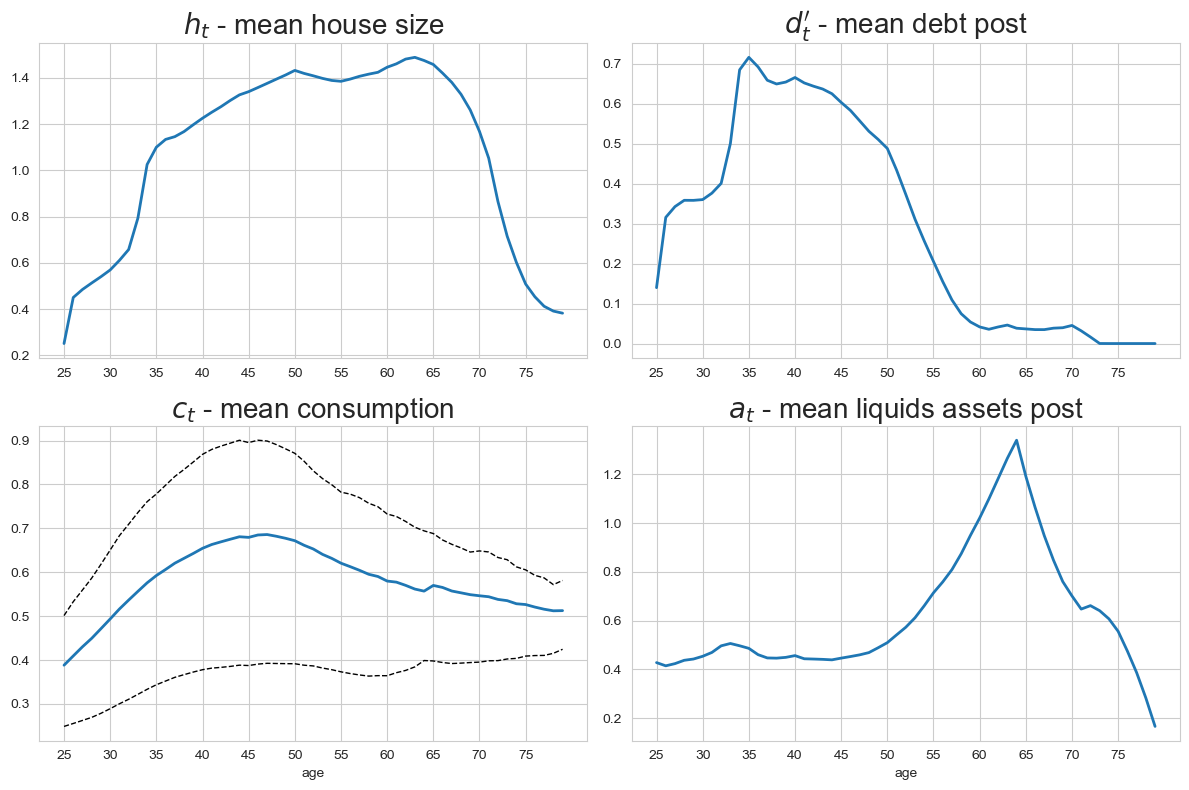

In [22]:
figs.lifecycle_full(model_nodeduct)

### 2.0 Aggregate moments in alternative model

In [23]:
names_targ_nd, moments_targ_nd = ana.model_moments_targ(model_nodeduct)
print('Targeted moments from baseline model without interest rate deductibility:')
for i in range(len(names_targ_nd)):
    print(f'  {names_targ_nd[i]} = {moments_targ_nd[i]:.4f}')

Targeted moments from baseline model without interest rate deductibility:
  Aggregate net worth / (annual) labour income = 1.4069
  Annual fraction of houses sold = 0.0394
  Home ownership rate of <35 y.o. = 0.1940
  Mean NW at age 75 / mean NW at age 50 = 0.7323
  Share of households leaving no bequest = 0.4707
  Taxes to labour income = 0.3557


In [54]:
names_nd, moments_nd = ana.model_moments(model_nodeduct)
print('Untargeted moments from baseline model without interest rate deductibility:')
for i in range(len(names_nd)):
    print(f'  {names_nd[i]} = {moments_nd[i]:.4f}')

Untargeted moments from baseline model without interest rate deductibility:
  Homeowner share = 0.3483
  Mean house size = 3.0319
  Average housing expenditure = 0.0769
  Mean mortgage size = 1.8349
  Share of homeowners with mortgage = 0.4670
  DA mortgage share = 0.2409
  Average LTV ratio = 0.6480
  Average DTI ratio = 1.0845
  Gini wealth coefficient = 0.6971


### 2.1 Consumption equivalent variation between baseline and alternative

In [25]:
from simulate import calc_utility
from EconModel import jit

with jit(model_baseline) as model:
    calc_utility(model.sim,model.par)

assert len(np.unique(model_baseline.sim.utility)) == par.simN, 'utility is not unique'
assert np.sum(np.isinf(model_baseline.sim.utility)) == 0, 'there are individuals with negative infinite utility'

In [65]:
with jit(model_baseline) as model:
    par1 = model.par
    sim1 = model.sim

with jit(model_nodeduct) as model:
    par2 = model.par
    sim2 = model.sim

cev = ana.cev(sim1,sim2,par1,par2,guess=1.0,N=10)
#fig = plt.figure(figsize=(8,6))
#ax = fig.add_subplot(111)
#ax.hist(cev,bins=500)
#ax.set_xlabel('consumption equivalent variation')
#ax.set_ylabel('frequency')


CEV computation did not converge for individual  0  after  0  iterations
utility1[n] =  -151.7229291186278
utility_now =  -245.44423457378372
guess_vec[n] =  1.61771352556658
CEV computation did not converge for individual  0  after  5000  iterations
utility1[n] =  -151.7229291186278
utility_now =  -204.75203304251005
guess_vec[n] =  1.3495127877634125
CEV computation did not converge for individual  1  after  0  iterations
utility1[n] =  -126.25642337778581
utility_now =  -106.30143809591661
guess_vec[n] =  0.8419487520079697
CEV computation did not converge for individual  1  after  5000  iterations
utility1[n] =  -126.25642337778581
utility_now =  -110.40739834511514
guess_vec[n] =  0.8744695548261568
CEV computation did not converge for individual  2  after  0  iterations
utility1[n] =  -126.77689839081515
utility_now =  -101.70437473143973
guess_vec[n] =  0.802231132188734
CEV computation did not converge for individual  2  after  5000  iterations
utility1[n] =  -126.7768983908151

In [58]:
cev

array([1.34951279])

In [43]:
model_nodeduct.simulate(do_utility=True)

model simulated in 16.4 secs
utility calculated in 10.2 secs


## Debugging tools

### Test solving the household problem for a few periods

In [ ]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = par.T-1
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    hhp.last_period_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    #hhp.postdecision_compute_v_bar_q.py_func(t,sol,par)
    hhp.postdecision_compute_v_bar_q_rent(t,sol,par)
    hhp.postdecision_compute_v_bar_q_own(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')

### Sanity checks

In [ ]:
# check NaNs in relevant part of sol.inv_v_bar

#nan_mat_v = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of q at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_v.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_v}')
#
## check zero or negative entries in relevant part of sol.inv_v_bar
#zero_mat_v= np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of c_endo at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_v.shape[0]} zero or negative entries')
#print(f'the zero indices/negative are {zero_mat_v}')

par = model_baseline.par
sol = model_baseline.sol

t = 21
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

#nan_mat_q = np.argwhere(np.isnan(sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,:]))
#print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_q.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_q}')

# check zero or negative entries in relevant part of sol.inv_v_bar
zero_mat_q= np.argwhere(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,9].size}')
print(f'there are {zero_mat_q.shape[0]} zero or negative entries')
print(f'the zero indices/negative are {zero_mat_q}')
